In [80]:
import cv2
import numpy as np
from math import *
import matplotlib.pyplot as plt
%matplotlib inline

读入原始答题卡图像

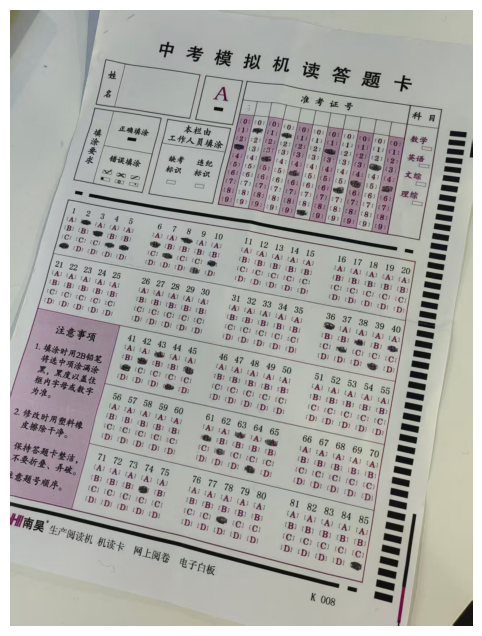

In [122]:
img_path = "images/test2.jpg"
img = cv2.imread(img_path)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

检测黑线

检测到 4 条直线
线段 0: (731,603)-(1201,686), 长度=477.3px, 角度=10.0°
线段 1: (532,561)-(946,634), 长度=420.4px, 角度=10.0°
线段 2: (11,1367)-(545,1501), 长度=550.6px, 角度=14.1°
线段 3: (381,544)-(685,593), 长度=307.9px, 角度=9.2°
[9.156421326484065, 10.000084558344959, 10.014934016665483, 14.086724317871482]
建议答题卡逆时针旋转校正角度:10.0°


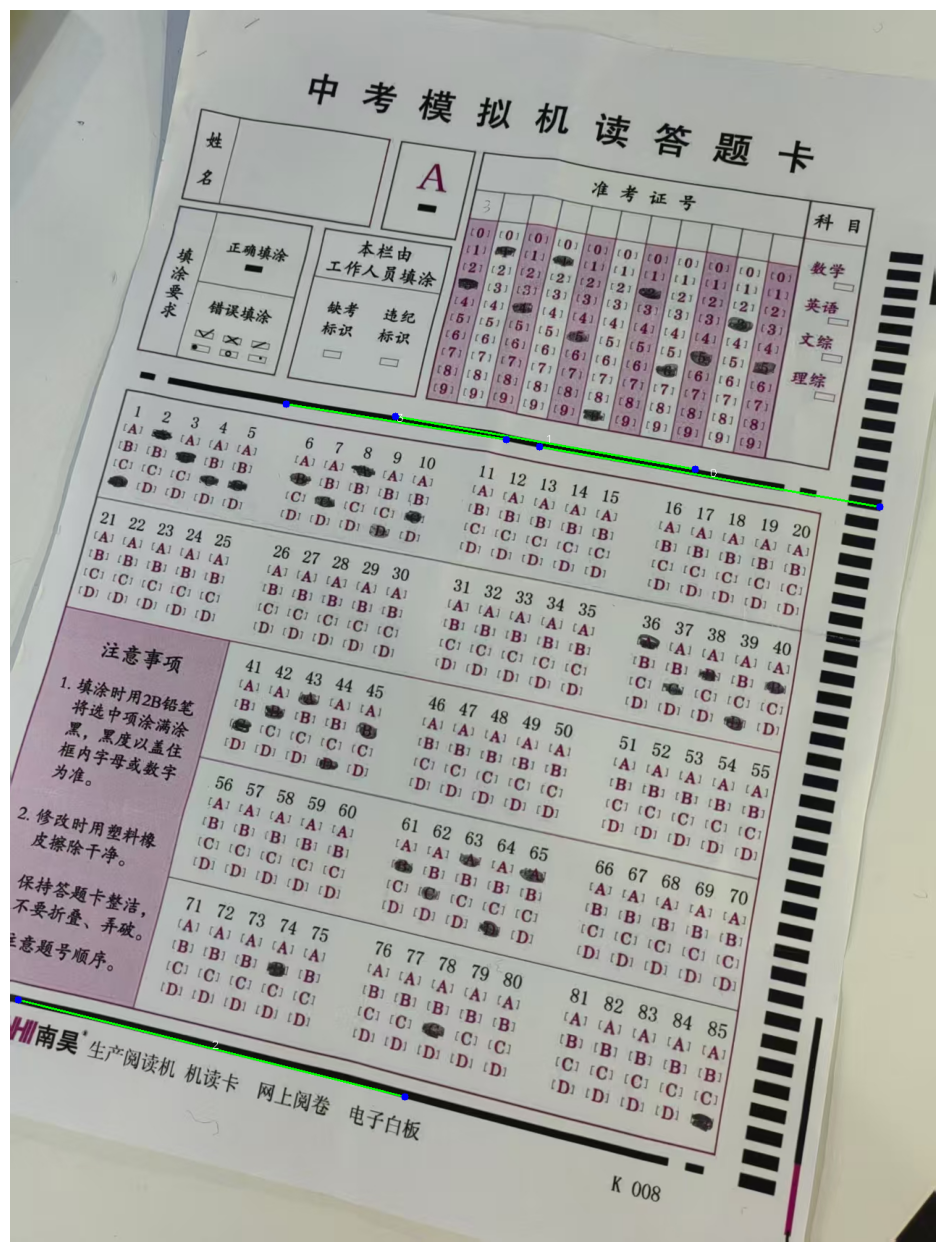

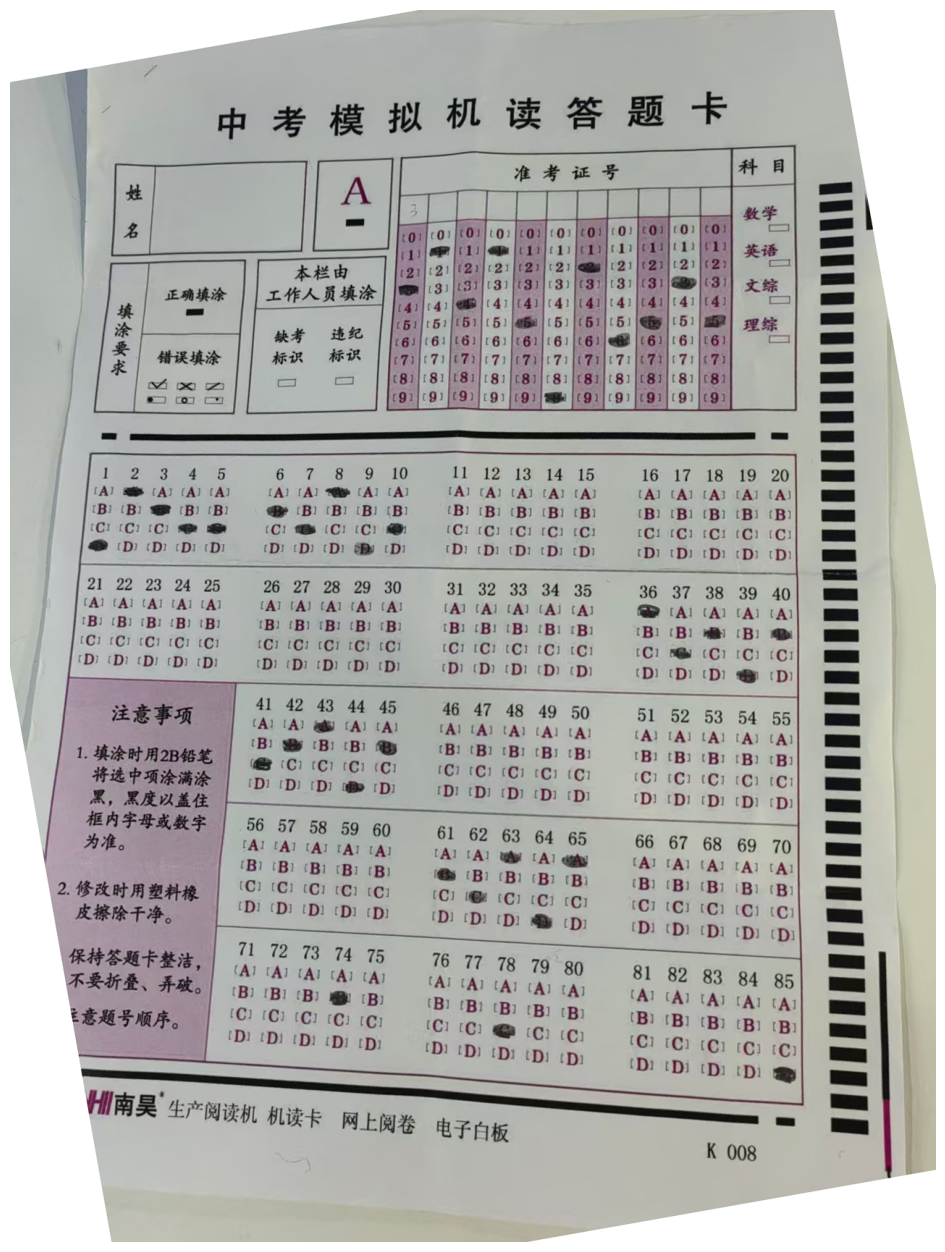

In [123]:
#转灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#高斯模糊去噪
is_blur = True
blur = cv2.GaussianBlur(gray, (3, 3), 0) if is_blur else gray
#二值化（检测黑线）,<30 -> white, >30 -> black
_, binary= cv2.threshold(blur, 30, 255, cv2.THRESH_BINARY_INV)
#闭运算缝合边缘/黑块
kernel = np.ones((5, 5), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
#边缘检测
edges = cv2.Canny(binary, 50, 150, apertureSize=3)
#闭运算缝合边缘
#kernel = np.ones((5, 5), np.uint8)
#edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
#霍夫变换直线检测
lines = cv2.HoughLinesP(edges,
                       rho=1,                # 距离分辨率（像素）
                       theta=np.pi/180,      # 角度分辨率（弧度）
                       threshold=250,         # 投票阈值 -> 控制检测灵敏度（值小检测更多直线）
                       minLineLength=200,    # 最小线段长度
                       maxLineGap=100)        # 最大线段间隙

black_lines = img.copy()

angle_list = []
if lines is not None:
    print(f"检测到 {len(lines)} 条直线")

    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]

        # 绘制绿色直线，线宽2
        cv2.line(black_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # 可选：标注端点（红色圆点）
        cv2.circle(black_lines, (x1, y1), 5, (255, 0, 0), -1)
        cv2.circle(black_lines, (x2, y2), 5, (255, 0, 0), -1)

        # 可选：显示线段编号
        mid_x = (x1 + x2) // 2
        mid_y = (y1 + y2) // 2
        cv2.putText(black_lines, str(i), (mid_x, mid_y),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # 打印线段信息
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        if abs(angle)<45:
             angle_list.append(angle)
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        print(f"线段 {i}: ({x1},{y1})-({x2},{y2}), "
              f"长度={length:.1f}px, 角度={angle:.1f}°")
else:
    print("未检测到直线")

# 取角度中位值作为校正角度
sorted_angle_list = sorted(angle_list)
rotation_angle = sorted_angle_list[len(sorted_angle_list)//2]
print(sorted_angle_list)
print(f"建议答题卡逆时针旋转校正角度:{rotation_angle:.1f}°")

angle_threshold =  1
if abs(rotation_angle) > angle_threshold:
    #旋转校正图像
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h),
                                 flags=cv2.INTER_CUBIC,
                                 borderMode=cv2.BORDER_CONSTANT,
                                 borderValue=(255, 255, 255))
else:
    print("无需校正！")

figure_plot = True

if figure_plot:
    '''
    plt.figure(figsize=(20, 16))
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(20, 16))
    plt.imshow(blur, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(20, 16))
    plt.imshow(binary, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(20, 16))
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(20, 16))
    plt.imshow(edges_closed, cmap='gray')
    plt.axis('off')
    plt.show()
    '''

    plt.figure(figsize=(20, 16))
    plt.imshow(cv2.cvtColor(black_lines, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(20, 16))
    plt.imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


识别黑块，确定水平网格线

一共检测到 2011 个轮廓
筛选出 68 个有效轮廓
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

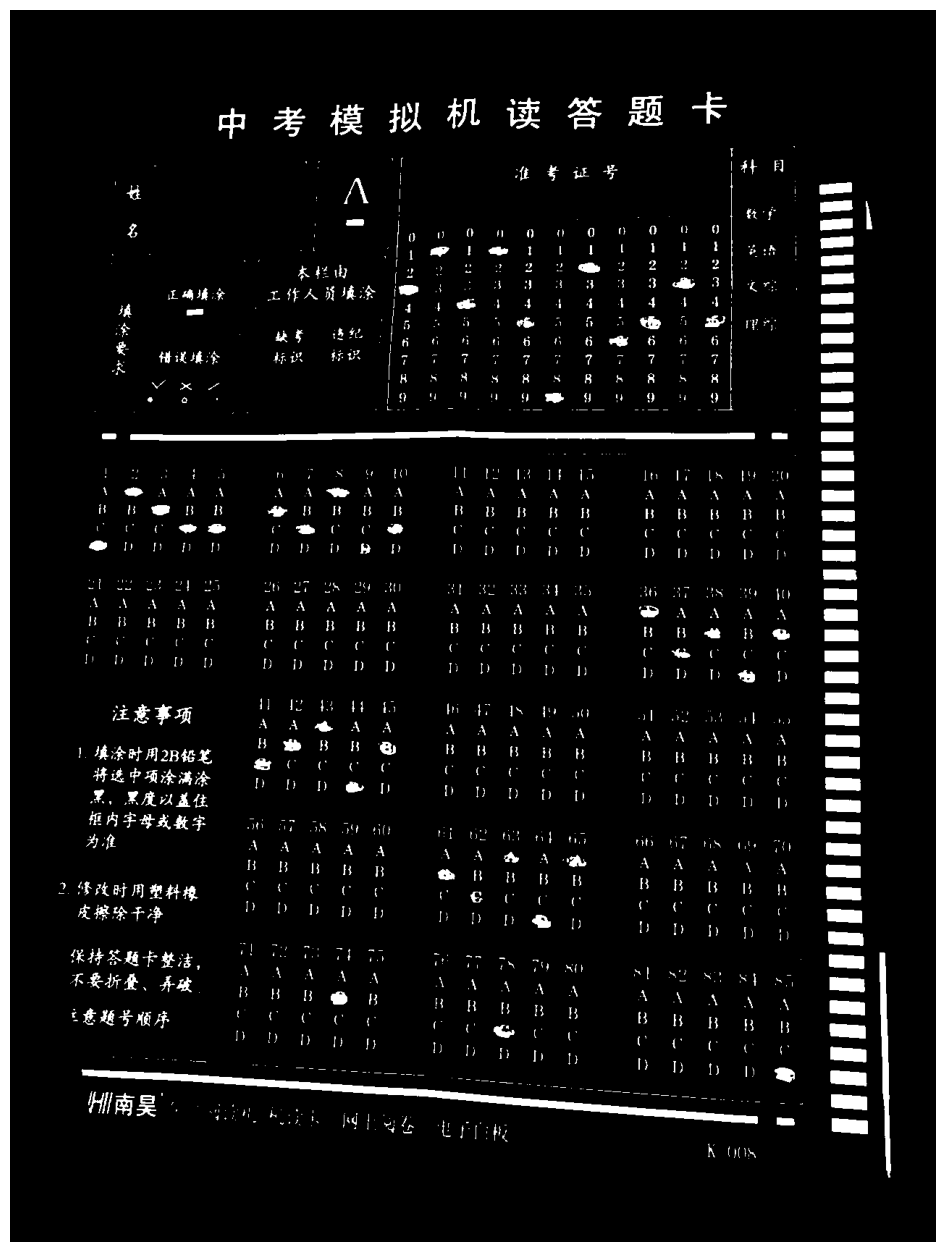

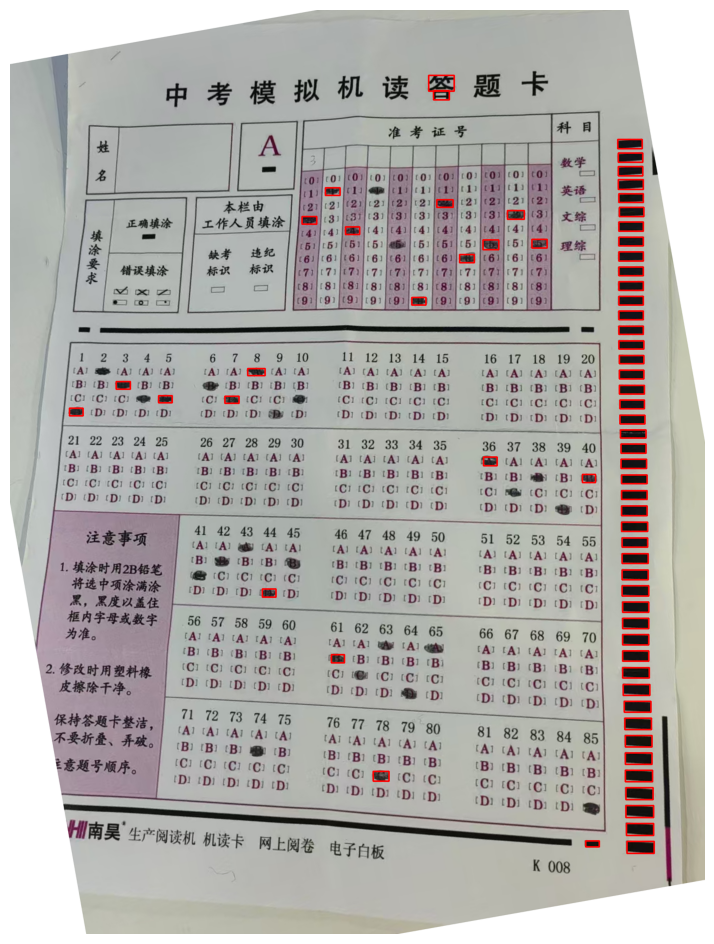

In [126]:
#转灰度图
gray2 = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
#高斯模糊去噪
is_blur2 = True
blur2 = cv2.GaussianBlur(gray2, (3, 3), 0) if is_blur2 else gray2
_, binary2 = cv2.threshold(blur2, 70, 255, cv2.THRESH_BINARY_INV)

#检测轮廓
contours, _ = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

marked_img_simple = rotated.copy()
print(f"一共检测到 {len(contours)} 个轮廓")
valid_cnts = 0
area_list = []
aspect_ratio_list = []

# 绘制所有轮廓
for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w/h
    area_list.append(area)
    aspect_ratio_list.append(aspect_ratio)
    if area>200 and area<2000 and aspect_ratio>1.5 and aspect_ratio<5:
        # 绘制边界框
        cv2.rectangle(marked_img_simple, (x, y), (x + w, y + h), (0,0,255), 2)
        valid_cnts = valid_cnts + 1
print(f"筛选出 {valid_cnts} 个有效轮廓")
print(sorted(area_list))
print(sorted(aspect_ratio_list))

plt.figure(figsize=(20, 16))
plt.imshow(binary2, cmap='gray')
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 12))
plt.imshow(cv2.cvtColor(marked_img_simple, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()